In [128]:
import random
random.seed(7)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve, roc_curve, precision_score, recall_score, average_precision_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV


from scipy import sparse

from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [2]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='ignore'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    def get_feature_names(self):
        return self.columns.tolist()
    
class DataFrameImputer(TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [116]:
# source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')


In [3]:
X_train = pd.read_csv('/Users/seda/Documents/Human_Activity_Fitbit/UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None)
y_train = pd.read_csv('/Users/seda/Documents/Human_Activity_Fitbit/UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None)

In [4]:
ncolumns = pd.read_csv('/Users/seda/Documents/Human_Activity_Fitbit/UCI HAR Dataset/features.txt', sep='\s+', header=None, index_col=0).reset_index(drop=True)

In [5]:
ncolumns[1] = ncolumns[1].str.replace(',','_')
ncolumns[1] = ncolumns[1].str.replace('(','_')
ncolumns[1] = ncolumns[1].str.replace(')','_')
ncolumns[1] = ncolumns[1].str.replace('-','_')
ncols = list(set(ncolumns[1]))

In [6]:
X_train.columns = ncolumns[1]

In [7]:
y_train.columns = ['label']

In [8]:
train = pd.concat([X_train,y_train],axis=1)

In [11]:
label = 'label'
num_attribs = X_train.columns

In [13]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs))
])

feature_union = FeatureUnion([
    ('num_pipe', num_pipeline)])

full_pipeline = Pipeline([
    ('features', num_pipeline),
    ('model', LogisticRegression(multi_class='multinomial', solver='newton-cg')),
])

In [14]:
model = full_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
model.score(X_train, y_train)

0.9925190424374319

In [68]:
model.score(X_test, y_test)

0.9606379368849678

In [20]:
train_pred = full_pipeline.predict(X_train) 

In [21]:
confusion_matrix(y_train,train_pred)

array([[1226,    0,    0,    0,    0,    0],
       [   0, 1073,    0,    0,    0,    0],
       [   0,    0,  986,    0,    0,    0],
       [   0,    0,    0, 1260,   26,    0],
       [   0,    0,    0,   29, 1345,    0],
       [   0,    0,    0,    0,    0, 1407]])

In [23]:
X_test = pd.read_csv('/Users/seda/Documents/Human_Activity_Fitbit/UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None)
y_test = pd.read_csv('/Users/seda/Documents/Human_Activity_Fitbit/UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None)

X_test.columns = ncolumns[1]
y_test.columns = ['label']
test = pd.concat([X_test,y_test],axis=1)

In [25]:
test_pred = full_pipeline.predict(X_test)
confusion_matrix(y_test, test_pred)

array([[494,   0,   2,   0,   0,   0],
       [ 26, 444,   1,   0,   0,   0],
       [  4,  13, 403,   0,   0,   0],
       [  0,   3,   0, 432,  56,   0],
       [  0,   0,   0,  11, 521,   0],
       [  0,   0,   0,   0,   0, 537]])

Confusion matrix, without normalization
[[494   0   2   0   0   0]
 [ 26 444   1   0   0   0]
 [  4  13 403   0   0   0]
 [  0   3   0 432  56   0]
 [  0   0   0  11 521   0]
 [  0   0   0   0   0 537]]
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.  ]
 [0.06 0.94 0.   0.   0.   0.  ]
 [0.01 0.03 0.96 0.   0.   0.  ]
 [0.   0.01 0.   0.88 0.11 0.  ]
 [0.   0.   0.   0.02 0.98 0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


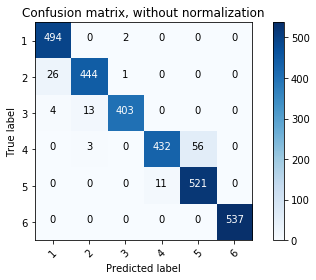

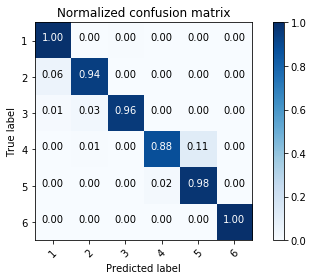

In [72]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


class_names = [1,2,3,4,5,6]
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [73]:
y_pred_cv = cross_val_predict(full_pipeline, X_train, y_train, cv = 7)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [75]:
confusion_matrix(y_train, y_pred_cv)

array([[1153,   60,   13,    0,    0,    0],
       [  24, 1019,   29,    1,    0,    0],
       [   9,   47,  930,    0,    0,    0],
       [   0,    1,    0, 1196,   79,   10],
       [   0,    0,    0,  111, 1263,    0],
       [   0,    0,    2,    1,    3, 1401]])

In [76]:
y_pred_test_cv = cross_val_predict(full_pipeline, X_test, y_test, cv = 7)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [33]:
confusion_matrix(y_test, y_pred_test_cv)

array([[493,   0,   3,   0,   0,   0],
       [  7, 442,  22,   0,   0,   0],
       [  6,  14, 400,   0,   0,   0],
       [  0,   3,   0, 441,  44,   3],
       [  0,   0,   0,  46, 486,   0],
       [  0,   0,   0,   0,   1, 536]])

Confusion matrix, without normalization
[[493   0   3   0   0   0]
 [  7 442  22   0   0   0]
 [  6  14 400   0   0   0]
 [  0   3   0 441  44   3]
 [  0   0   0  46 486   0]
 [  0   0   0   0   1 536]]
Normalized confusion matrix
[[0.99 0.   0.01 0.   0.   0.  ]
 [0.01 0.94 0.05 0.   0.   0.  ]
 [0.01 0.03 0.95 0.   0.   0.  ]
 [0.   0.01 0.   0.9  0.09 0.01]
 [0.   0.   0.   0.09 0.91 0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


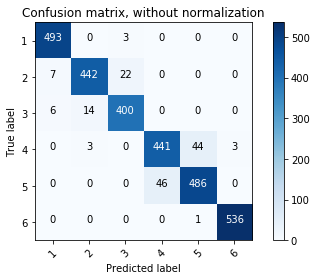

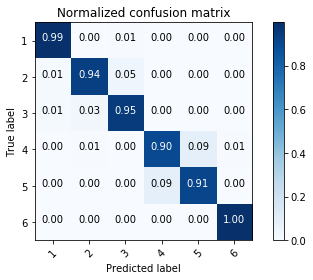

In [77]:
cnf_matrix = confusion_matrix(y_test, y_pred_test_cv)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [56]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 20, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [58]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [59]:
rf_random.best_params_

{'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10}

In [61]:
best_model = rf_random.best_estimator_

In [67]:
best_model.score(X_test, y_test)

0.9185612487275195

In [65]:
len(num_attribs)

561

In [78]:
test_pred_rf = best_model.predict(X_test)


Confusion matrix, without normalization
[[481   4  11   0   0   0]
 [ 38 426   7   0   0   0]
 [ 27  46 347   0   0   0]
 [  0   0   0 428  63   0]
 [  0   0   0  44 488   0]
 [  0   0   0   0   0 537]]
Normalized confusion matrix
[[0.97 0.01 0.02 0.   0.   0.  ]
 [0.08 0.9  0.01 0.   0.   0.  ]
 [0.06 0.11 0.83 0.   0.   0.  ]
 [0.   0.   0.   0.87 0.13 0.  ]
 [0.   0.   0.   0.08 0.92 0.  ]
 [0.   0.   0.   0.   0.   1.  ]]


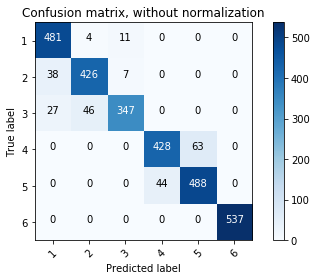

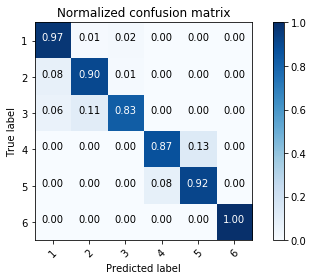

In [79]:
cnf_matrix = confusion_matrix(y_test, test_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [81]:
importances = rf_random.best_estimator_.feature_importances_

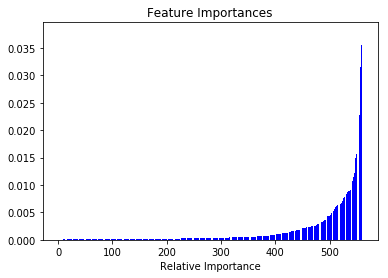

In [84]:
features = ncolumns[1]
indices = np.argsort(importances, )

plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='b', align='center')
#plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

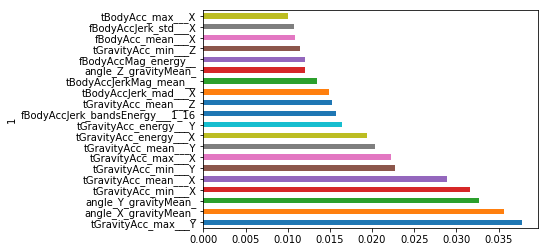

In [87]:
feat_importances = pd.Series(importances, index=ncolumns[1])
feat_importances.nlargest(20).plot(kind='barh')

In [99]:
# Use label_binarize to be multi-label like settings
y_testb = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6])
y_trainb = label_binarize(y_train, classes=[1, 2, 3, 4, 5, 6])


In [110]:
n_classes = y_testb.shape[1]

# Run classifier
classifier = OneVsRestClassifier(LinearSVC(random_state=4))
classifier.fit(X_train, y_trainb)


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=4, tol=0.0001,
     verbose=0),
          n_jobs=None)

In [119]:
y_scores = classifier.decision_function(X_test)

In [130]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = 6
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_testb[:, i],
                                                        y_scores[:, i])
    average_precision[i] = average_precision_score(y_testb[:, i], y_scores[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], t = precision_recall_curve(y_testb.ravel(), y_scores.ravel())
average_precision["micro"] = average_precision_score(y_testb, y_scores,average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.99')

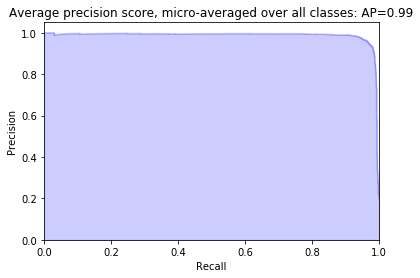

In [132]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

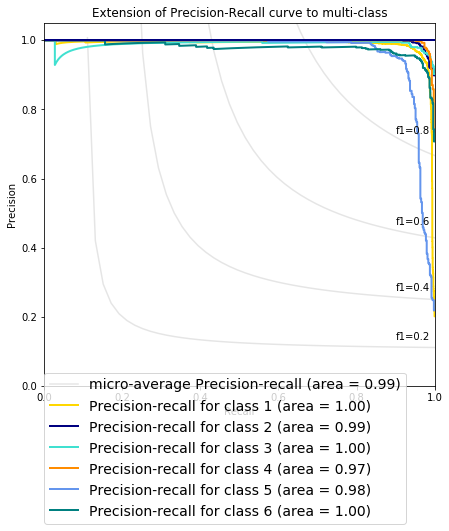

In [140]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
#labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i+1, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()


In [142]:
train.groupby(by = ['label'])['label'].count()

label
1    1226
2    1073
3     986
4    1286
5    1374
6    1407
Name: label, dtype: int64

In [153]:
top20_feat = list(feat_importances.nlargest(20).index)
bottom20_feat = list(feat_importances.nsmallest(20).index)

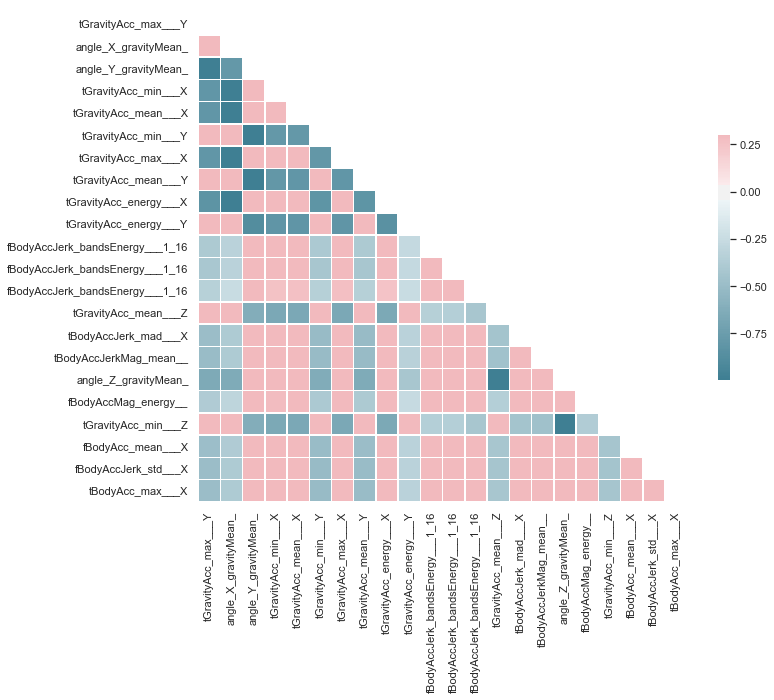

In [158]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = train[top20_feat]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

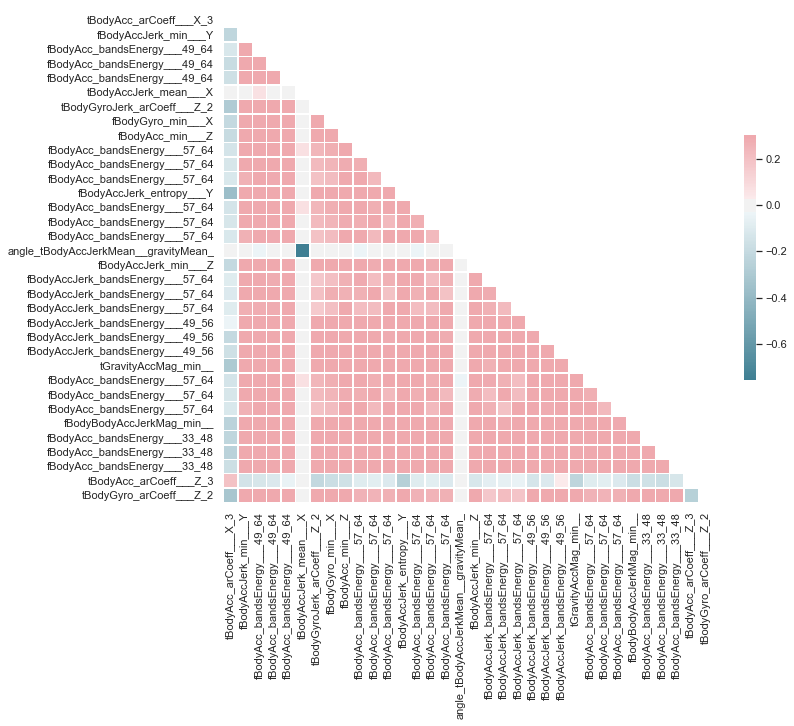

In [159]:
sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = train[bottom20_feat]

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})